In [1]:
# !pip install evaluate
# !pip install rouge-score bert_score
# !pip install scikit-learn
# !pip install streamlit
# !pip install matplotlib
# !pip install seaborn

In [2]:
from openai import OpenAI
import streamlit as st
import json
import os
import evaluate
import matplotlib.pyplot as plt
import helper  # Assuming helper is a module that contains the perform_knn_search function

%matplotlib inline

In [3]:
openai_client = OpenAI(api_key=st.secrets["openai"])

# OpenAI model answer function
def get_answer_openai(question, context):
    response = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": f"Answer the question based on the context:\n\nContext: {context}\n\nQuestion: {question}\nAnswer:"}
        ]
    )
    return response.choices[0].message.content

In [4]:
# Load evaluation metrics
rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')
meteor = evaluate.load('meteor')
exact_match = evaluate.load('exact_match')
f1 = evaluate.load('f1')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/deveshsurve/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/deveshsurve/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/deveshsurve/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
# Prepare the dataset
questions = []
reference_answers = []
with open('eval_data.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        questions.append(data['prompt'])
        reference_answers.append(data['referenceResponse'])


In [6]:
from opensearchpy import OpenSearch
import boto3
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

model = SentenceTransformer('all-MiniLM-L6-v2')

os_client = OpenSearch(
        hosts=[st.secrets["esurl"]],
        http_auth=(st.secrets["esuser"], st.secrets["espass"])
    )
aws_access_key_id = st.secrets["aws_access_key_id"]
aws_secret_access_key = st.secrets["aws_secret_access_key"]

# Create a session with the AWS credentials
session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='us-east-1'  # Replace with your desired region
)
# Check if GPT answers are already saved
if os.path.exists('gpt_answers.json') and os.path.exists('gpt_answers_with_context.json'):
    with open('gpt_answers.json', 'r') as f:
        gpt_answers_without_context = json.load(f)
    with open('gpt_answers_with_context.json', 'r') as f:
        gpt_answers_with_context = json.load(f)
else:
    # Generate answers using GPT without context
    gpt_answers_without_context = []
    for question in tqdm(questions):
        answer = get_answer_openai(question, context="")
        gpt_answers_without_context.append(answer)

    # Generate answers using GPT with context
    gpt_answers_with_context = []
    for question in tqdm(questions):
        # Get the context from the KNN search results
        similar_faqs = helper.perform_knn_search(os_client, "faqs_v3", question, model)
        context = "\n\n".join([f"Q: {q}\nA: {a}" for q, a in similar_faqs])
        answer = get_answer_openai(question, context)
        gpt_answers_with_context.append(answer)

    # Save GPT answers to files
    with open('gpt_answers.json', 'w') as f:
        json.dump(gpt_answers_without_context, f)
    with open('gpt_answers_with_context.json', 'w') as f:
        json.dump(gpt_answers_with_context, f)

/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# Compare generated answers with reference answers using evaluation metrics
rouge_scores_without_context = rouge.compute(predictions=gpt_answers_without_context, references=reference_answers)
rouge_scores_with_context = rouge.compute(predictions=gpt_answers_with_context, references=reference_answers)
bleu_scores_without_context = bleu.compute(predictions=gpt_answers_without_context, references=reference_answers)
bleu_scores_with_context = bleu.compute(predictions=gpt_answers_with_context, references=reference_answers)
meteor_scores_without_context = meteor.compute(predictions=gpt_answers_without_context, references=reference_answers)
meteor_scores_with_context = meteor.compute(predictions=gpt_answers_with_context, references=reference_answers)
exact_match_scores_without_context = exact_match.compute(predictions=gpt_answers_without_context, references=reference_answers)
exact_match_scores_with_context = exact_match.compute(predictions=gpt_answers_with_context, references=reference_answers)

In [8]:
# !pip install plotly

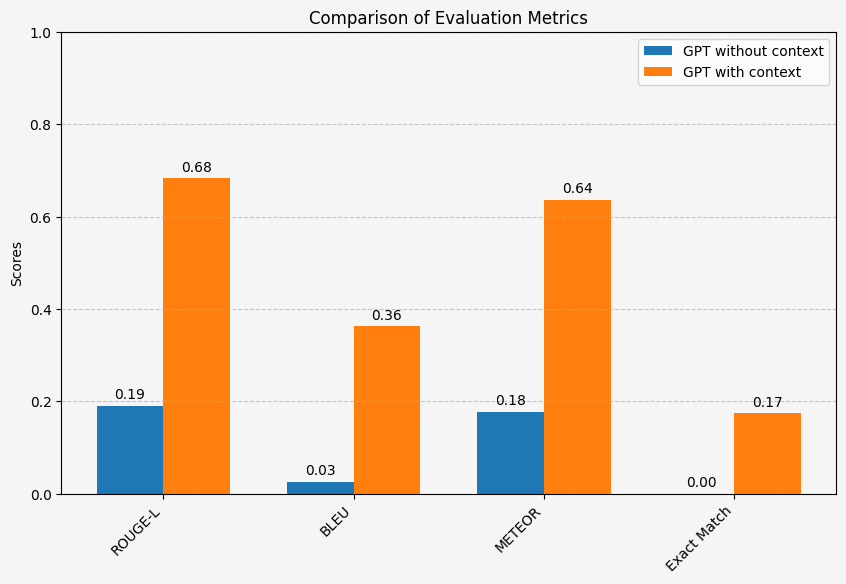

In [10]:
%matplotlib inline
# fig.tight_layout()
import matplotlib.pyplot as plt
import numpy as np

# Create a bar chart to visualize the scores for each evaluation metric
scores_without_context = [rouge_scores_without_context['rougeL'], bleu_scores_without_context['bleu'], meteor_scores_without_context['meteor'], exact_match_scores_without_context['exact_match']]
scores_with_context = [rouge_scores_with_context['rougeL'], bleu_scores_with_context['bleu'], meteor_scores_with_context['meteor'], exact_match_scores_with_context['exact_match']]
metrics = ['ROUGE-L', 'BLEU', 'METEOR', 'Exact Match']

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, scores_without_context, width, label='GPT without context', color='#1f77b4')
rects2 = ax.bar(x + width/2, scores_with_context, width, label='GPT with context', color='#ff7f0e')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Set the y-axis limit
ax.set_ylim([0, 1])

# Add a background color
fig.patch.set_facecolor('#f5f5f5')
ax.set_facecolor('#f5f5f5')

plt.show()
